In [1]:
import numpy as np
import os
from PIL import Image


In [2]:
train_cats_folder = "archive/training_set/training_set/cats"
train_dogs_folder = "archive/training_set/training_set/dogs"

test_cats_folder = "archive/test_set/test_set/cats"
test_dogs_folder = "archive/test_set/test_set/dogs"


In [3]:
def load_images(folder_cats, folder_dogs, image_size=(64,64), max_images=200):
    images = []
    labels = []

    for i, filename in enumerate(os.listdir(folder_cats)):
        if i >= max_images:
            break
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_cats, filename)
            img = Image.open(img_path).convert("RGB").resize(image_size)
            img_array = np.array(img).reshape(-1) / 255.0
            images.append(img_array)
            labels.append(0)

    for i, filename in enumerate(os.listdir(folder_dogs)):
        if i >= max_images:
            break
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_dogs, filename)
            img = Image.open(img_path).convert("RGB").resize(image_size)
            img_array = np.array(img).reshape(-1) / 255.0
            images.append(img_array)
            labels.append(1)

    X = np.array(images).T
    Y = np.array(labels).reshape(1, -1)
    return X, Y


In [4]:
X_train, Y_train = load_images(train_cats_folder, train_dogs_folder, max_images=200)
X_test, Y_test = load_images(test_cats_folder, test_dogs_folder, max_images=50)

print("Train data shape:", X_train.shape)
print("Train labels shape:", Y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", Y_test.shape)



Train data shape: (12288, 400)
Train labels shape: (1, 400)
Test data shape: (12288, 100)
Test labels shape: (1, 100)


In [5]:
#X_train = X_train / 255.
#X_test = X_test / 255.

#X_train = X_train.reshape(X_train.shape[0], -1).T  # (num_px*num_px*3, m_train)
#X_test = X_test.reshape(X_test.shape[0], -1).T

Y_train = Y_train.reshape(1, -1)
Y_test = Y_test.reshape(1, -1)


In [6]:
import numpy as np

# ---------------------------------
# Initialization
# ---------------------------------
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  # number of layers including input

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])*np.sqrt(2. / layer_dims[l - 1])  
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

# ---------------------------------
# Forward functions
# ---------------------------------
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

# ---------------------------------
# Cost function
# ---------------------------------
def compute_cost(AL, Y,parameters,lambd):
    #m = Y.shape[1]
    #cost = -1 / m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    #cost = np.squeeze(cost)
    #return cost
    m = Y.shape[1]
    
    # Cross-entropy cost
    cross_entropy_cost = - (1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    # L2 regularization cost
    L2_regularization_cost = 0
    L = len(parameters) // 2  # number of layers
    
    for l in range(1, L + 1):
        L2_regularization_cost += np.sum(np.square(parameters["W" + str(l)]))
    
    L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost
    
    # Total cost
    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    
    return cost

# ---------------------------------
# Backward functions
# ---------------------------------
def linear_backward(dZ, cache,lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T)+(lambd / m) * W 
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def linear_activation_backward(dA, cache, activation,lambd):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches,lambd):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[-1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
        dAL, current_cache, "sigmoid",lambd
    )

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu",lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# ---------------------------------
# Update parameters
# ---------------------------------
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters

# ---------------------------------
# Model function (training loop)
# ---------------------------------
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations,lambd, print_cost):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y,parameters,lambd)

        grads = L_model_backward(AL, Y, caches,lambd)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)

    return parameters,costs

# ---------------------------------
# Prediction function
# ---------------------------------
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1, m))

    AL, _ = L_model_forward(X, parameters)

    for i in range(AL.shape[1]):
        p[0, i] = 1 if AL[0, i] > 0.5 else 0

    print("Accuracy: " + str(np.mean((p[0, :] == y[0, :])) * 100) + '%')
    return p


In [7]:
layers_dims = [X_train.shape[0], 40,16,8, 1]


In [8]:
parameters,costs = L_layer_model(X_train, Y_train, layers_dims, learning_rate=0.001, num_iterations=5000,lambd=0.7, print_cost=True)


Cost after iteration 0: 0.8368783703079976
Cost after iteration 1000: 0.7385859682319429
Cost after iteration 2000: 0.6775140430906917
Cost after iteration 3000: 0.5919972019458877
Cost after iteration 4000: 0.46658129643952856


In [9]:
pred_train = predict(X_train, Y_train, parameters)
pred_test = predict(X_test, Y_test, parameters)

Accuracy: 97.0%
Accuracy: 60.0%


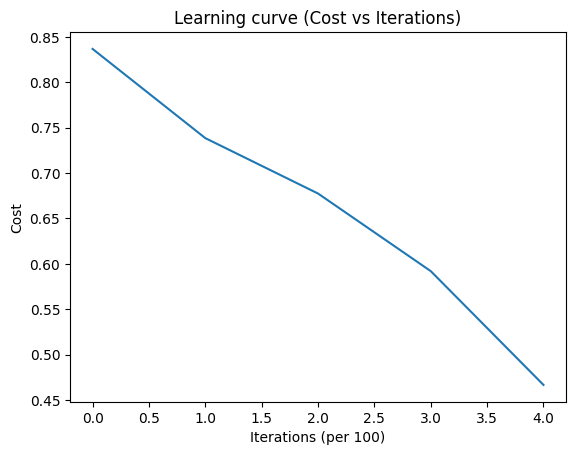

In [10]:
import matplotlib.pyplot as plt

plt.plot(np.squeeze(costs))
plt.ylabel('Cost')
plt.xlabel('Iterations (per 100)')
plt.title("Learning curve (Cost vs Iterations)")
plt.show()
